In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [118]:
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Yearly point extraction data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
#     print(df)

# df = df[df['Species_Code'] == 'A1'] ##eventually, you will want to do this

# ntimes = 16 # number of times you repeat each item
# yourlist = [2000,2001,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
# df['Year'] = [i for i in yourlist for _ in range(ntimes)]

df

# print(df.iloc[100,])

# for col in df.columns:
#     print(col)

,B1,B2,B3,B4,B5,B6,B7,flats,system:index,latitude,...,monitoringPurpose,Replicate,Year,speciesName,locationID,liveMass,Transect,longitude,B10,B11
0,0.0321,0.0662,0.0636,0.2729,0.1777,0.2942,0.0779,0.000064,0,37.395746,...,EOYB,a,2000,Spartina alterniflora,1,841.6,B,-75.876094,NaN,NaN
1,0.0321,0.0662,0.0636,0.2729,0.1777,0.2942,0.0779,0.000064,1,37.395746,...,EOYB,b,2000,Spartina alterniflora,1,214.4,B,-75.876094,NaN,NaN
2,0.0321,0.0662,0.0599,0.2684,0.1691,0.2942,0.0779,0.000462,2,37.395746,...,EOYB,a,2000,Spartina alterniflora,1,963.2,C,-75.876094,NaN,NaN
3,0.0321,0.0662,0.0599,0.2684,0.1691,0.2942,0.0779,0.000462,3,37.395746,...,EOYB,b,2000,Spartina alterniflora,1,0.0,C,-75.876094,NaN,NaN
4,0.0345,0.0662,0.0636,0.2641,0.1805,0.2942,0.0861,0.000057,4,37.395746,...,EOYB,a,2000,Spartina alterniflora,1,841.6,A,-75.876094,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,0.0436,0.0621,0.0666,0.1545,0.1194,0.2973,0.0595,0.000065,189,37.481998,...,EOYB,a,1999,Spartina alterniflora,3,0.0,B,-75.819360,NaN,NaN
1860,0.0395,0.0579,0.0567,0.1117,0.0808,0.2964,0.0522,0.012653,190,37.481998,...,EOYB,a,1999,Spartina alterniflora,1,129.6,C,-75.819360,NaN,NaN
1861,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,191,37.481998,...,EOYB,a,1999,Spartina alterniflora,2,388.8,C,-75.819360,NaN,NaN
1862,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,192,37.481998,...,EOYB,b,1999,Spartina alterniflora,2,315.2,C,-75.819360,NaN,NaN


In [119]:
##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

##IMPORTANT: again, these bands between landsat 5 and 8 may not be able to be compared directly

##Variables from Byrd et al. 2018 (make sure calculations are accurate):
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df = df.drop(columns=['latitude','longitude'])
df['ident'] = df['Latitude'] / df['Longitude'] + df['Year'] ##Just crazy enough that it might work

df

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df)

,B1,B2,B3,B4,B5,B6,B7,flats,system:index,marshName,...,NIR_band,SWIR1_band,SWIR2_band,savi,wdrvi5,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r,ident
0,0.0321,0.0662,0.0636,0.2729,0.1777,0.2942,0.0779,0.000064,0,Box Tree,...,0.2729,0.1777,0.0779,0.375314,0.364159,-0.020031,0.346897,-0.555872,0.101060,1999.507147
1,0.0321,0.0662,0.0636,0.2729,0.1777,0.2942,0.0779,0.000064,1,Box Tree,...,0.2729,0.1777,0.0779,0.375314,0.364159,-0.020031,0.346897,-0.555872,0.101060,1999.507147
2,0.0321,0.0662,0.0599,0.2684,0.1691,0.2942,0.0779,0.000462,2,Box Tree,...,0.2684,0.1691,0.0779,0.377581,0.382792,-0.049960,0.346897,-0.550101,0.130624,1999.507143
3,0.0321,0.0662,0.0599,0.2684,0.1691,0.2942,0.0779,0.000462,3,Box Tree,...,0.2684,0.1691,0.0779,0.377581,0.382792,-0.049960,0.346897,-0.550101,0.130624,1999.507143
4,0.0345,0.0662,0.0636,0.2641,0.1805,0.2942,0.0861,0.000057,4,Box Tree,...,0.2641,0.1805,0.0861,0.363356,0.349859,-0.020031,0.314796,-0.508281,0.150301,1999.507152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,0.0436,0.0621,0.0666,0.1545,0.1194,0.2973,0.0595,0.000065,189,Woodland Farm,...,0.1545,0.1194,0.0595,0.182846,0.074035,0.034965,0.175024,-0.443925,-0.056305,1998.505641
1860,0.0395,0.0579,0.0567,0.1117,0.0808,0.2964,0.0522,0.012653,190,Woodland Farm,...,0.1117,0.0808,0.0522,0.123429,-0.007552,-0.010471,0.188912,-0.363026,-0.041322,1998.505646
1861,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,191,Woodland Farm,...,0.1389,0.1169,0.0631,0.200977,0.192787,-0.028926,0.115342,-0.375248,0.146231,1998.505647
1862,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,192,Woodland Farm,...,0.1389,0.1169,0.0631,0.200977,0.192787,-0.028926,0.115342,-0.375248,0.146231,1998.505647


In [120]:
# df = df[df['ndvi'].notna()] ##later?
# df['siteName'] = df['site_id'].copy()

# display(df)
# for col in df.columns:
#     print(col)

In [121]:
##Average plot value (grouped, more or less, by lat/long, for each year)

# va_means = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Average biomass/va_meanmass.csv')
# display(va_means)

# df_first = pd.merge(df, va_means)
# df_first ##n is boiled down to 92 here - at first glance it looks correct, but make sure it is!


In [122]:
##Daymet data; yearly average
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm.rename(columns={'site_id':'siteName'}, inplace=True)
dm = dm.drop(columns=['latitude','longitude'])

# dm['ident'] = dm['Latitude']/dm['Longitude']

dm['ident'] = dm['Latitude'] / dm['Longitude'] + dm['Year'] ##Just crazy enough that it might work

display(dm)

,dayl,prcp,srad,swe,tmax,tmin,vp,system:index,marshName,siteName,...,Code,Longitude,monitoringPurpose,Replicate,Year,speciesName,locationID,liveMass,Transect,ident
0,43225.171875,3.546236,311.112579,0.000000,20.336401,10.515385,1439.916382,0,Box Tree,Box_Tree,...,BTCC,-75.876056,EOYB,b,1999,Spartina alterniflora,1,0.00,C,1998.507143
1,43225.171875,3.555687,311.353333,0.000000,20.326044,10.495000,1437.849121,1,Box Tree,Box_Tree,...,BTC2,-75.877045,EOYB,b,1999,Spartina alterniflora,3,272.48,C,1998.507144
2,43225.171875,3.546236,311.112579,0.000000,20.336401,10.515385,1439.916382,2,Box Tree,Box_Tree,...,BTDC,-75.875969,EOYB,b,1999,Spartina alterniflora,1,0.00,D,1998.507139
3,43225.171875,3.555687,311.353333,0.000000,20.326044,10.495000,1437.849121,3,Box Tree,Box_Tree,...,BTAC,-75.876249,EOYB,b,1999,Spartina alterniflora,1,0.00,A,1998.507152
4,43225.171875,3.555687,311.353333,0.000000,20.326044,10.495000,1437.849121,4,Box Tree,Box_Tree,...,BTA3,-75.878189,EOYB,b,1999,Spartina alterniflora,4,0.00,A,1998.507153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,43225.062500,3.305769,310.027924,0.000000,20.746950,11.474368,1548.789673,32,Oyster,Oyster,...,OSBC,-75.929133,EOYB,b,2017,Spartina alterniflora,1,480.00,B,2016.508916
1860,43225.062500,3.305769,310.027924,0.000000,20.746950,11.474368,1548.789673,33,Oyster,Oyster,...,OSBC,-75.929133,EOYB,a,2017,Spartina alterniflora,1,402.88,B,2016.508916
1861,43224.957031,3.342610,307.995300,0.000000,21.011868,11.759917,1576.207886,34,Gator Tract,Gator,...,GTC2,-75.944280,EOYB,a,2017,Spartina alterniflora,3,42.72,C,2016.510592
1862,43225.171875,3.430330,303.402832,1.031209,20.270796,11.017665,1547.654297,0,Box Tree,Box_Tree,...,BTCC,-75.876056,EOYB,a,2018,Spartina alterniflora,1,255.04,C,2017.507143


In [123]:
##Loading elevation data

elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Point elevation/VA_DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)
elev_10m.rename(columns={'site_id':'siteName'}, inplace=True)

elev_10m['ident'] = elev_10m['Latitude'] / elev_10m['Longitude'] + elev_10m['Year'] ##Just crazy enough that it might work

display(elev_10m) ##More data here than other datasets

,Elevation,system:index,Replicate,Year,locationID,siteName,Latitude,Longitude,Transect,ident
0,0.157865,0,b,1999,1,Gator,37.167147,-75.940768,A,1998.510577
1,0.157865,1,a,1999,1,Gator,37.167147,-75.940768,A,1998.510577
2,0.157865,2,a,2000,1,Gator,37.167147,-75.940768,A,1999.510577
3,0.157865,3,b,2000,1,Gator,37.167147,-75.940768,A,1999.510577
4,0.157865,4,b,2001,1,Gator,37.167147,-75.940768,A,2000.510577
...,...,...,...,...,...,...,...,...,...,...
1896,0.744798,1896,a,1999,1,Woodland_Farm,37.482293,-75.819265,A,1998.505636
1897,0.744798,1897,a,2000,1,Woodland_Farm,37.482293,-75.819265,A,1999.505636
1898,0.744798,1898,b,2000,1,Woodland_Farm,37.482293,-75.819265,A,1999.505636
1899,0.744798,1899,a,2002,1,Woodland_Farm,37.482293,-75.819265,A,2001.505636


In [140]:
##Merging daymet, elevation, and flats data
df0 = pd.merge(df, dm, on = ['ident', 'Replicate'], how = 'left') ##Difficulties merging! NEED TO CHECK
df1 = pd.merge(df0, elev_10m, on = ['ident', 'Replicate'], how = 'left')

display(df0)
display(df1)

print(sum(df1['liveMass_x'] - df1['liveMass_y']))
df1.rename(columns={'liveMass_x':'liveMass'}, inplace=True)

# for col in df1.columns:
#     print(col)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'va_df1.csv')
# df1.to_csv(out_csv, index = False)

,B1,B2,B3,B4,B5,B6,B7,flats,system:index_x,marshName_x,...,siteName_y,Latitude_y,Code_y,Longitude_y,monitoringPurpose_y,Year_y,speciesName_y,locationID_y,liveMass_y,Transect_y
0,0.0321,0.0662,0.0636,0.2729,0.1777,0.2942,0.0779,0.000064,0,Box Tree,...,Box_Tree,37.395746,BTBC,-75.876094,EOYB,2000,Spartina alterniflora,1,841.6,B
1,0.0321,0.0662,0.0636,0.2729,0.1777,0.2942,0.0779,0.000064,1,Box Tree,...,Box_Tree,37.395746,BTBC,-75.876094,EOYB,2000,Spartina alterniflora,1,214.4,B
2,0.0321,0.0662,0.0599,0.2684,0.1691,0.2942,0.0779,0.000462,2,Box Tree,...,Box_Tree,37.396051,BTCC,-75.876056,EOYB,2000,Spartina alterniflora,1,963.2,C
3,0.0321,0.0662,0.0599,0.2684,0.1691,0.2942,0.0779,0.000462,3,Box Tree,...,Box_Tree,37.396051,BTCC,-75.876056,EOYB,2000,Spartina alterniflora,1,0.0,C
4,0.0345,0.0662,0.0636,0.2641,0.1805,0.2942,0.0861,0.000057,4,Box Tree,...,Box_Tree,37.395461,BTAC,-75.876249,EOYB,2000,Spartina alterniflora,1,841.6,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,0.0436,0.0621,0.0666,0.1545,0.1194,0.2973,0.0595,0.000065,189,Woodland Farm,...,Woodland_Farm,37.481601,WFB2,-75.818583,EOYB,1999,Spartina alterniflora,3,0.0,B
1880,0.0395,0.0579,0.0567,0.1117,0.0808,0.2964,0.0522,0.012653,190,Woodland Farm,...,Woodland_Farm,37.481756,WFCC,-75.819638,EOYB,1999,Spartina alterniflora,1,129.6,C
1881,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,191,Woodland Farm,...,Woodland_Farm,37.481484,WFC1,-75.819201,EOYB,1999,Spartina alterniflora,2,388.8,C
1882,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,192,Woodland Farm,...,Woodland_Farm,37.481484,WFC1,-75.819201,EOYB,1999,Spartina alterniflora,2,315.2,C


,B1,B2,B3,B4,B5,B6,B7,flats,system:index_x,marshName_x,...,liveMass_y,Transect_y,Elevation,system:index,Year,locationID,siteName,Latitude,Longitude,Transect
0,0.0321,0.0662,0.0636,0.2729,0.1777,0.2942,0.0779,0.000064,0,Box Tree,...,841.6,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0321,0.0662,0.0636,0.2729,0.1777,0.2942,0.0779,0.000064,1,Box Tree,...,214.4,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0321,0.0662,0.0599,0.2684,0.1691,0.2942,0.0779,0.000462,2,Box Tree,...,963.2,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0321,0.0662,0.0599,0.2684,0.1691,0.2942,0.0779,0.000462,3,Box Tree,...,0.0,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0345,0.0662,0.0636,0.2641,0.1805,0.2942,0.0861,0.000057,4,Box Tree,...,841.6,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888,0.0436,0.0621,0.0666,0.1545,0.1194,0.2973,0.0595,0.000065,189,Woodland Farm,...,0.0,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1889,0.0395,0.0579,0.0567,0.1117,0.0808,0.2964,0.0522,0.012653,190,Woodland Farm,...,129.6,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1890,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,191,Woodland Farm,...,388.8,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,192,Woodland Farm,...,315.2,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.0


In [157]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from numpy import loadtxt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor ##try KNN next!
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

df1 = df1[df1['ndvi'].notna()]
df1 = df1[df1['liveMass'].notna()]
df1 = df1[df1['Latitude'].notna()]
df1 = df1[(df1['flats'] < 0.1)] ##This might actually hurt for now -  need to go back and LOOK AT IMAGES THAT WERE SELECTED FOR ANALYSIS

xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

yargs=df1['liveMass'] 

size_x = 0.2
seed = 3
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

Mean Absolute Error: 252.62332389743577
Mean Squared Error: 123406.23969778538
Root Mean Squared Error: 351.29224258128073
The r squared is: 0.02958666466646398
0.02958666466646398
testing r2 is: 0.02958666466646398
training r2 is: 0.8137536783377628
NRMSE is: 0.26539060995201313
MEAN BASELINE:
Mean Absolute Error: 312.8420976013234
Root Mean Squared Error: 371.3458914468456


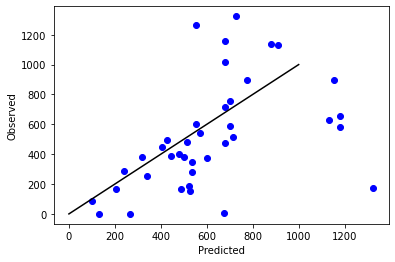

test data correlation coefficient is: 0.46573126712335267
train data correlation coefficient is: 0.9095664468973639


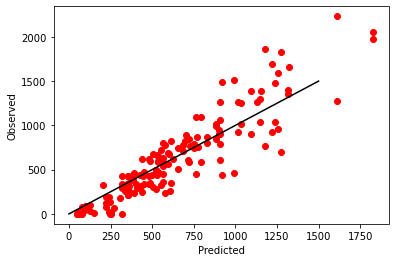

In [158]:
plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1000], [0, 1000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1500], [0, 1500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

In [146]:
##k-fold cross validation; similar to original random forest regression code

predictors = df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi']]
targets = df1['liveMass'] 

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.datasets import load_boston

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

##from: https://stackoverflow.com/questions/55270431/how-to-correctly-perform-cross-validation-in-scikit-learn

{'fit_time': array([0.11170316, 0.108711  , 0.11073422, 0.10472202, 0.1046989 ]),
 'score_time': array([0.00897598, 0.00797868, 0.00698376, 0.0069747 , 0.00698113]),
 'test_r2': array([ 0.03501277, -0.02661127,  0.23888711,  0.2064519 ,  0.40348755]),
 'test_neg_root_mean_squared_error': array([-468.71131752, -425.36530201, -397.51785687, -423.00621089,
        -340.61845561])}